# Evaluation Metrics

In [61]:
import pandas as pd
import numpy as np
import copy
import os
from scipy.stats import friedmanchisquare
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# change to your local path to project below
project_path = '/home/jorge/Insync/jorgitoje@gmail.com/OneDrive/Documentos/JORGE/EDUCATION/MASTER_DATASCIENCE/Semester1/AdvancedStatistics/GroupProject/KDS_Statistics_GroupProject'
# TO DO:
# - Include CART method when already having data correct
# - Add tie correction to W
# -  

In [62]:
featureranks_basepath = os.path.join(project_path, 'data')
all_ranks_all_methods_long = pd.DataFrame()

# Put all ranks into one csv
for file in os.listdir(featureranks_basepath):
    if file.endswith('.csv') and file != 'featureranks_ALLMETHODS.csv':
        df = pd.read_csv(os.path.join(featureranks_basepath, file), sep=";")
        all_ranks_all_methods_long = pd.concat([all_ranks_all_methods_long, df], axis=0)

# Save all ranks together
all_ranks_all_methods_long.to_csv(os.path.join(project_path, 'data', 'featureranks_ALLMETHODS.csv'), sep=";", index=False)
all_ranks_all_methods_long = all_ranks_all_methods_long.query('method != "Lasso_regression"') # temporarily take out these methods


In [63]:
all_ranks_all_methods_long.query('method != "CART" and method != "Lasso_regression"').groupby(['method', 'dataset'])['feature_name'].count()

method             dataset             
Linear_regression  Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
Random_forest      Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
Ridge_regression   Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
elastic_net        Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
Name: feature_name, dtype: int64

## Kendall's W

### Using friedmanchisquare
(DOES NOT seem to work and requires manually putting all columns)

In [64]:

# spRes = friedmanchisquare(data_kendall['PCA'].to_numpy(), data_kendall['RandomForest'].to_numpy(), data_kendall['linear_regression'].to_numpy())
# spRes = friedmanchisquare(*[data_kendall[column] for column in data_kendall.columns])
# friedmanchisquare()
# selData()
# n = data_kendall.shape[0]
# k = data_kendall.shape[1]
# Q = spRes[0]
# print(f"n: {n},k: {k}, Q: {Q}")

In [65]:
# W = Q / (n*(k-1))
# print(f"W: {W}")

### Using direct formula

In [66]:
def calculate_kendallW(data_kendall, tie_correction=False):
    '''_summary_

    Args:
        data_kendall (pd.dataframe): Datafrem containing as columns the feature
        selection methods and as values ranks to each feature in the same order.

    Returns:
        W: Kendall's W coefficient
    '''
    n = data_kendall.shape[0] # number of features/objects
    k = data_kendall.shape[1] # numbe of raters/methods

    # Sum of each item ranks
    sums = data_kendall.sum(axis=1, numeric_only=True).to_numpy()
    # Mean of ranking sums
    Rbar = sums.mean()
    Rbar
    # Sum of squared deviations from the mean
    S = np.sum([(np.array(sums)[x] - Rbar) ** 2 for x in range(n)])
    if not tie_correction:
        W = (12 * S) / (k ** 2 * (n ** 3 - n))
    else:
        # TO DO: implement tie correction
        T=3 
        numerator = 12*np.sum([np.array(sums)[x] for x in range(n)]) - 3*(k**2)*n*(n+1)**2
        print(numerator)
        denominator = ((k**2)*n*(n**2 - 1) - k*T)
        W = numerator /  denominator
        return None

    return W

## Top–k overlap

In [67]:
def calculate_topkoverlap(datatopk, k=5):

    data_all = datatopk.copy(deep=True)

    n = len(data_all)

    assert len(data_all) >= k, f"Maximum value for k is {n}, which is total number of features"

    methods = data_all.columns.to_list()
    data_all['feature_id'] = data_all.index

    all_toplists = []

    for method in methods:
        data_temp = data_all.filter(items=['feature_id', method]) \
            .sort_values(method).head(k)['feature_id'].to_list()
        all_toplists.append(data_temp)
    union_lists= np.unique(all_toplists)
    intersection_lists = set.intersection(*map(set, all_toplists))

    topk_overlap = len(intersection_lists)/len(union_lists)
        
    return topk_overlap


In [69]:
all_ranks_all_methods_long.query('dataset == "USA_houseprices_2014"').pivot( index=['dataset', 'feature_name'], columns=['method'], 
        values=['feature_rank']).reset_index()

dataset               feature_name feature_rank  \
method                                                          CART   
0       USA_houseprices_2014                  bathrooms          4.0   
1       USA_houseprices_2014                   bedrooms         11.0   
2       USA_houseprices_2014                       city          6.0   
3       USA_houseprices_2014                  condition          1.0   
4       USA_houseprices_2014                     floors         12.0   
5       USA_houseprices_2014              have_basement         13.0   
6       USA_houseprices_2014              sqft_basement          9.5   
7       USA_houseprices_2014                sqft_living          2.0   
8       USA_houseprices_2014                   sqft_lot          5.0   
9       USA_houseprices_2014                   statezip          3.0   
10      USA_houseprices_2014                       view          9.5   
11      USA_houseprices_2014                 waterfront          7.5   
12      USA_houseprices_2014  year_since_1st_renovation          7.5   

                                                                     
method Linear_regression Random_forest Ridge_regression elastic_net  
0                    9.0           6.0              2.0         9.0  
1                    3.0           9.0             10.0         3.0  
2                    8.0           3.0              7.0         8.0  
3                    6.0           9.0              6.0         6.0  
4                   12.5          11.0             10.0        12.0  
5                   10.5          13.0             13.0        11.0  
6                    6.0           6.0              5.0         7.0  
7                    1.0           1.0              1.0         1.0  
8                    2.0           4.0              8.0         2.0  
9                   10.5           2.0             10.0        10.0  
10                   6.0           8.0              4.0         5.0  
11                   4.0          12.0              3.0         4.0  
12                  12.5           5.0             12.0        13.0

## Hypothesis testing for all datasets

In [57]:
def perform_hypothesistest(all_ranks_all_methods_long, dataset_name, alpha = 0.05): 
    # Transform to long for better manipulation
    data_ranks_wide = all_ranks_all_methods_long.query('dataset == @dataset_name').pivot( index=['dataset', 'feature_name'], columns=['method'], 
        values=['feature_rank']).reset_index()

    # Calculate Kendall's W
    data_kendall = data_ranks_wide['feature_rank'].astype(int)
    W = calculate_kendallW(data_kendall, tie_correction=False)
    n = data_kendall.shape[0]
    k = data_kendall.shape[1]

    # Perform test of significance
    degrees_of_freedom = n - 1
    chisquared_alpha = chi2.ppf(q = alpha, df = degrees_of_freedom)
    chisquared_statistic = k *(n-1) * W
    test_passed = chisquared_statistic >= chisquared_alpha

    # Calculate k-overlaps
    k_overlaps = {}
    for i in range(1, n+1):
        k_overlaps[i] = calculate_topkoverlap(data_kendall, k=i)

    # Print results
    print(f"RESULTS FOR DATASET '{dataset_name}'")
    print(f"There are {n} features and {k} raters")
    print(f"Kendall's W: {W}")
    print(f"Top-5 overlap: {k_overlaps[5]}")
    print(f"Top-10 overlap: {k_overlaps[10]}")
    print(f"Statistic value(alpha={alpha}): {chisquared_statistic}")
    print(f"Chi2 (alpha={alpha}, {degrees_of_freedom} dof): {chisquared_alpha}") # Tabled value
    if test_passed:
        print("We reject null hypothesis and conclude that H1: W ≠ 0.")
    else:
        print("We cannot reject null hypothesis H0: W = 0")
    
    print('-------------------------------------------------------------------')


    return W, k_overlaps, chisquared_statistic,chisquared_alpha, test_passed

RESULTS FOR DATASET 'USA_houseprices_2014'
There are 13 features and 5 raters
Kendall's W: 0.540929839391378
Top-5 overlap: 0.09090909090909091
Top-10 overlap: 0.5384615384615384
Statistic value(alpha=0.05): 32.45579036348268
Chi2 (alpha=0.05, 12 dof): 5.226029488392639
We reject null hypothesis and conclude that H1: W ≠ 0.
-------------------------------------------------------------------
RESULTS FOR DATASET 'Bike_sharing'
There are 12 features and 5 raters
Kendall's W: 0.7267132867132867
Top-5 overlap: 0.6666666666666666
Top-10 overlap: 0.6666666666666666
Statistic value(alpha=0.05): 39.96923076923077
Chi2 (alpha=0.05, 11 dof): 4.574813079322224
We reject null hypothesis and conclude that H1: W ≠ 0.
-------------------------------------------------------------------
RESULTS FOR DATASET 'Airbnb_price'
There are 18 features and 5 raters
Kendall's W: 0.49763559224859544
Top-5 overlap: 0.2222222222222222
Top-10 overlap: 0.3333333333333333
Statistic value(alpha=0.05): 42.299025341130616


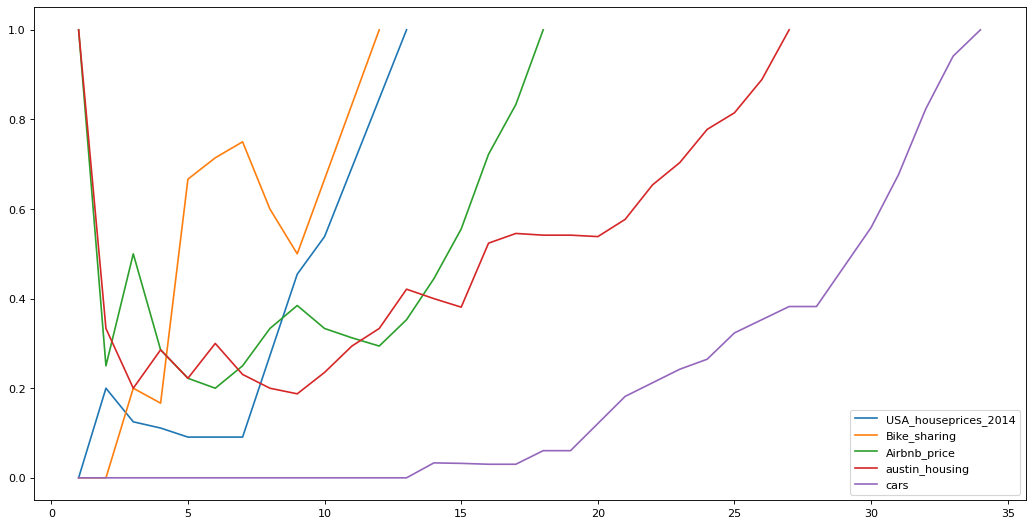

In [60]:
results = []
fig, ax = plt.subplots(figsize=(16, 8), dpi=80)

for dataset_name in all_ranks_all_methods_long['dataset'].unique():

    # Perform hypothesis test
    W, k_overlaps, chisquared_statistic,chisquared_alpha, test_passed = perform_hypothesistest(all_ranks_all_methods_long, dataset_name)

    # Ploting: k-overlaps
    ax.plot(k_overlaps.keys(),k_overlaps.values(), label=dataset_name)

    # Add all results to list
    results.append(
        [W, k_overlaps, chisquared_statistic,chisquared_alpha, test_passed]
    )

ax.legend()
fig.savefig(os.path.join(project_path, 'img',"Topk_overlaps_alldataset.png") )


## Plotting

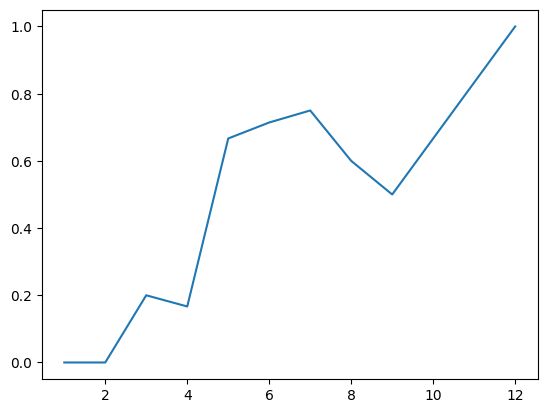

In [37]:
data = results[1][1]

fig, ax = plt.subplots()

x=data.keys()
y=data.values()
ax.plot(x,y)